# Training Engineering and Model Assessments on the AI-ready PHIPS Image Classification Dataset

##### This notebook performs a thorough analysis of training strategies and model assessment of the Random Forest Classifier model for classifying features in the "PHIPS_CrystalHabitAI_Dataset.nc" dataset. Random Forest Classifier was determined to be the best-performing model in the `autoML_hyperparamter_tuning.iypnb` notebook

## Understanding Cross-Validation and Train-Validation-Test Splits

##### **Cross-Validation (CV):** A technique that divides the training data into multiple folds, repeatedly trains and tests the model on these folds, and then averages the results to give a robust estimate of model performance.

* k-Fold Cross-Validation: The most common form, where the data is divided into `k` folds. The model is trained on `k-1` folds and tested on the remaining fold, rotating through each fold as a test set once.

##### **Train-Validation-Test Split:** This approach separates the dataset into three parts:
* Training Set: Used to fit/train the model.
* Validation Set: Used to tune hyperparameters or evaluate models during training to avoid overfitting.
* Test Set: A final hold-out set used solely for evaluating the model's performance after training is complete. This data is not seen by the model during training or tuning.

## 1. Data pre-processing 

In [2]:
# Import basic packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Define the file path of the dataset
file_path = 'C:\\Users\\carpa\\MLGEO2024_Snowflake_Classification\\PHIPS_CrystalHabitAI_Dataset.nc'

# Open the NetCDF file using xarray
ds = xr.open_dataset(file_path)

In [6]:
# Flatten the image arrays (convert each image from a 2D array to a 1D vector)
image_arrays = np.array([image_array.flatten() for image_array in ds['image_array'].values])

# Scales features in data using statistics that are robust to outliers.
# Before applying PCA (a dimensionality reduction method), it's important to scale the data so that each feature contributes equally to the analysis.

from sklearn.preprocessing import RobustScaler

# Apply Robust Scaling
scaler = RobustScaler()
scaled_data = scaler.fit_transform(image_arrays)

from sklearn.decomposition import PCA

# Apply PCA with the optimal number of components (63 in this case, obtained from the 'autoML_hyperparameter_tuning.ipynb' notebook)
pca = PCA(n_components=63)
pca_result = pca.fit_transform(scaled_data)

# Convert the PCA results into a DataFrame
pca_columns = [f'PC{i+1}' for i in range(63)]
pca_df = pd.DataFrame(pca_result, columns=pca_columns)
pca_df['habit_type'] = ds['label'].values  # Adding the target label

## 1. Implementing Cross-Validation and Train-Val-Test Splits

##### Start with a Train-Validation-Test Split

Split the full dataset into 80% training + validation and 20% test. This way, the test set remains unseen until final evaluation.
Within the 80% training set, split again into 75% for training and 25% for validation. This provides a validation set for tuning without using the test data.

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Step 1: Train-Test Split (80/20)
X = pca_df.drop(columns='habit_type')  # Features
y = pca_df['habit_type']               # Target labels

# Split 80% for training+validation, 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train-Validation Split (within the 80%)
# Split again to get 75% training and 25% validation of the training set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

##### Perform Cross-Validation on the Training Set

Apply a 5-fold cross-validation on the training set, using the `cross_val_score` function, which gives an average accuracy across 5 folds. This provides a robust measure of model performance across different subsets of data. After cross-validation, train the model on the full training set and validate it on the validation set. This step helps refine the model and ensures it generalizes well without relying on the test set.

In [10]:
# Step 3: Perform Cross-Validation on the Training Set (e.g., 5-fold CV)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=230, max_depth=7, criterion='entropy', random_state=42)

In [12]:
# Perform 5-fold CV on the training set
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Accuracy Scores: [0.39622642 0.35849057 0.22641509 0.26415094 0.36538462]
Mean CV Accuracy: 0.322133526850508


#####  Model Training and Validation

After cross-validation, train the model on the full training set and validate it on the validation set. This step helps refine the model and ensures it generalizes well without relying on the test set.

In [43]:
# Step 4: Train the Model on Full Training Data and Validate
# Train on the full training set and evaluate on the validation set
model.fit(X_train, y_train)
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions, average='weighted')
print("Validation Accuracy:", val_accuracy)
print("Validation F1 Score:", val_f1)

Validation Accuracy: 1.0
Validation F1 Score: 1.0


##### Final Test Evaluation

After tuning and finalizing the model, train on the combined training + validation data and evaluate on the hold-out test set. This gives an unbiased performance measure of the model.

In [45]:
# Step 5: Final Evaluation on the Test Set
# After tuning, train on combined training+validation set for final test evaluation
model.fit(X_train_val, y_train_val)
test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)

Test Accuracy: 0.3977272727272727
Test F1 Score: 0.4058368200114612


##### A test accuracy of ~38.6% and test F1 score of ~38.0% suggests moderate performance of the Random Forest Classifer model. It correctly classified only about 38.6% of test samples. Given the multi-class nature of the problem, this may indicate the model is struggling to differentiate between classes effectively. The F1 Score, which balances precision and recall, is close to the accuracy score, which implies that precision and recall are similar. This balance is helpful in multi-class problems, where it’s crucial to handle both false positives and false negatives effectively.

## 2. Implementing Stratified Cross-Validation

##### The current approach (cross-validation and a single train-validation-test split) provides a general measure of performance but may not fully capture *generality* if the data includes diverse subsets with varying characteristics (e.g., different ice crystal types, lighting conditions, or image scales). To ensure robust generalization across all data variations, stratified cross-validation will be implemented, which is a technique that may better demonstrate model performance on diverse subsets.

##### **On Stratified Cross-Validation:**
* What It Does: Ensures that each fold in cross-validation has a similar distribution of classes, maintaining class diversity across all training and validation sets.
* Why It Helps: This reduces the risk of over- or under-representing any specific class in a single fold and provides a better generalization measure across all types of ice crystals.

In [18]:
# Implementing Stratified K-Fold Cross-Validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

print("Stratified K-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

Stratified K-Fold Cross-Validation Accuracy Scores: [0.41509434 0.28301887 0.33962264 0.30188679 0.40384615]
Mean Accuracy: 0.34869375907111755
Standard Deviation: 0.05298526657843778


##### A mean accuracy of 32.6% suggests that the current model configuration and features are not effectively capturing class distinctions in the dataset. The standard deviation, which is close to 3%, shows that the model’s performance fluctuates across different data folds, possibly due to class overlap or difficulty in distinguishing between some classes.

## Understanding Bootstrapping and Bagging
##### **Bootstrapping:** A resampling method where we repeatedly sample with replacement from the original dataset to create multiple “bootstrap samples.” Each sample may have some data points repeated and others left out.
##### **Bagging:** Stands for Bootstrap Aggregating. It involves training a model on each bootstrap sample and then averaging or voting on the predictions across models to improve performance and reduce variance. Random Forest, for instance, is a classic example of bagging applied to decision trees.

## 1. Applying Bootstrapping and Bagging to Different Models
##### For this demonstration, the top 5 best-performing models (determined in the `autoML_hyperparamter_tuning.iypnb` notebook) will be used: Random Forest, Extra Trees, Gradient Boosting Classifier, Light Gradient Boosting Machine (LightGBM), and Logistic Regression. Bootstrapping and bagging will be manually applied to these models

In [20]:
# Split the data
X = pca_df.drop(columns='habit_type')  # Features
y = pca_df['habit_type']               # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform y_train
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform y_test using the same encoder
y_test_encoded = label_encoder.transform(y_test)

In [28]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 640.0 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.4 MB 1.1 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.4 MB 2.1 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.4 MB 2.3 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.4 MB 2.6 MB/s eta 0:00:01
   ------------------- -------------------- 0.7/1.4 MB 2.6 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.4 MB 2.6 MB/s eta 0:00:01
   ------------------------- -------------- 0.9/1.4 MB 2.7 MB/s eta 0:00:01
   ------------------------------ --------- 1.1/1.4 MB 2.7 MB/s eta 0:00:01
   --------------------------------- ------ 1.2/1.4 MB 2.7 MB/s eta 0:00:01
   ------------------------------------- -- 1.4/1.4 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 2.7 MB/s eta 0:00:00


In [29]:
# Perform bagging on each model and print accuracy
# Use the encoded y values in all model evaluations
import time
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Results storage
results = []

# Bagged Random Forest
start_time = time.time()
bagged_rf = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42),
    n_estimators=10, bootstrap=True, random_state=42
)
bagged_rf.fit(X_train, y_train_encoded)
train_time_rf = time.time() - start_time
accuracy_rf = accuracy_score(y_test_encoded, bagged_rf.predict(X_test))
results.append(("Bagged Random Forest", train_time_rf, accuracy_rf))
print(f"Bagged Random Forest - Training Time: {train_time_rf:.4f} seconds - Accuracy: {accuracy_rf:.4f}")

Bagged Random Forest - Training Time: 0.9359 seconds - Accuracy: 0.3636


In [30]:
# Bagged Extra Trees
start_time = time.time()
bagged_et = BaggingClassifier(
    estimator=ExtraTreesClassifier(n_estimators=50, max_depth=7, random_state=42),
    n_estimators=10, bootstrap=True, random_state=42
)
bagged_et.fit(X_train, y_train_encoded)
train_time_et = time.time() - start_time
accuracy_et = accuracy_score(y_test_encoded, bagged_et.predict(X_test))
results.append(("Bagged Extra Trees", train_time_et, accuracy_et))
print(f"Bagged Extra Trees - Training Time: {train_time_et:.4f} seconds - Accuracy: {accuracy_et:.4f}")

Bagged Extra Trees - Training Time: 0.4987 seconds - Accuracy: 0.3295


In [59]:
# Bagged Gradient Boosting
start_time = time.time()
bagged_gbc = BaggingClassifier(
    estimator=GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42),
    n_estimators=10, bootstrap=True, random_state=42
)
bagged_gbc.fit(X_train, y_train_encoded)
train_time_gbc = time.time() - start_time
accuracy_gbc = accuracy_score(y_test_encoded, bagged_gbc.predict(X_test))
results.append(("Bagged Gradient Boosting", train_time_gbc, accuracy_gbc))
print(f"Bagged Gradient Boosting - Training Time: {train_time_gbc:.4f} seconds - Accuracy: {accuracy_gbc:.4f}")


Bagged Gradient Boosting - Training Time: 24.3933 seconds - Accuracy: 0.3523


In [34]:
# Bagged LightGBM with warnings suppressed
start_time = time.time()
bagged_lgbm = BaggingClassifier(
    estimator=LGBMClassifier(n_estimators=50, max_depth=7, random_state=42, verbose=-1),
    n_estimators=10, bootstrap=True, random_state=42
)
bagged_lgbm.fit(X_train, y_train_encoded)
train_time_lgbm = time.time() - start_time
accuracy_lgbm = accuracy_score(y_test_encoded, bagged_lgbm.predict(X_test))
results.append(("Bagged LightGBM", train_time_lgbm, accuracy_lgbm))
print(f"Bagged LightGBM - Training Time: {train_time_lgbm:.4f} seconds - Accuracy: {accuracy_lgbm:.4f}")

Bagged LightGBM - Training Time: 1.7470 seconds - Accuracy: 0.3750


In [51]:
# Bagged Logistic Regression
start_time = time.time()
bagged_lr = BaggingClassifier(
    estimator=LogisticRegression(max_iter=1000, solver='saga', random_state=42),
    n_estimators=10, bootstrap=True, random_state=42
)
bagged_lr.fit(X_train, y_train_encoded)
train_time_lr = time.time() - start_time
accuracy_lr = accuracy_score(y_test_encoded, bagged_lr.predict(X_test))
results.append(("Bagged Logistic Regression", train_time_lr, accuracy_lr))
print(f"Bagged Logistic Regression - Training Time: {train_time_lr:.4f} seconds - Accuracy: {accuracy_lr:.4f}")

C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

Bagged Logistic Regression - Training Time: 10.8479 seconds - Accuracy: 0.3750


C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [53]:
# Bagged Logistic Regression
start_time = time.time()
bagged_lr = BaggingClassifier(
    estimator=LogisticRegression(max_iter=2000, solver='saga', random_state=42),
    n_estimators=10, bootstrap=True, random_state=42
)
bagged_lr.fit(X_train, y_train_encoded)
train_time_lr = time.time() - start_time
accuracy_lr = accuracy_score(y_test_encoded, bagged_lr.predict(X_test))
results.append(("Bagged Logistic Regression", train_time_lr, accuracy_lr))
print(f"Bagged Logistic Regression - Training Time: {train_time_lr:.4f} seconds - Accuracy: {accuracy_lr:.4f}")

C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

Bagged Logistic Regression - Training Time: 47.7294 seconds - Accuracy: 0.3409


C:\Users\carpa\anaconda3_\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [54]:
# Bagged Logistic Regression
start_time = time.time()
bagged_lr = BaggingClassifier(
    estimator=LogisticRegression(max_iter=10000, solver='saga', random_state=42),
    n_estimators=10, bootstrap=True, random_state=42
)
bagged_lr.fit(X_train, y_train_encoded)
train_time_lr = time.time() - start_time
accuracy_lr = accuracy_score(y_test_encoded, bagged_lr.predict(X_test))
results.append(("Bagged Logistic Regression", train_time_lr, accuracy_lr))
print(f"Bagged Logistic Regression - Training Time: {train_time_lr:.4f} seconds - Accuracy: {accuracy_lr:.4f}")

Bagged Logistic Regression - Training Time: 138.4653 seconds - Accuracy: 0.2955


##### In general, the tested ensemble learning methods have comparable results to the best models evaluated in the auto-ML notebook. While not competent either, as they more often than not misclassify the observations, the best performing methods in this case (Logistic Regression and Light GBM) achieve an accuracy of 37.5%, which is less than one percent lower than the 37.99% of the most accurate model, Random Forest, and definitely more desirable than the 9.09% which would be expected of random classification. Out of the ensemble methods, however, the superior option is Light GBM, as it is clearly more efficient by taking less than 1.75 seconds to run, in comparison to the 10.85 seconds that Logistic Regression takes. If those times seem excessive, another competent option is the bagged version of Random Forest, as it only takes 0.94 seconds while achieving an accuracy of 36.36%. The remaining options are simply outclassed by the rest.

##### A detail worth mentioning about the Logistic Regression Method is the convergence warnings that arise when running it. These usually mean that the model ran for a certain amount of time, but that it was not enough to fully optimize its parameters, leading to a potentially suboptimal performance. While this would normally be solved by increasing the number of iterations, doubling the number did not solve the convergence problem, and increasing it tenfold did solve the problem, but dramatically dropped the accuracy. Since both of these adjustments greatly increased the time it took for the model to run, they are not worth incorporating, and for that reason, the original 1000 iteration case is preferable.

## 2. Visualize Model Performance (focusing on the Random Forest model)

##### Plotting Learning Curves Using Cross-Validation
Learning curves show the model's accuracy or loss over training rounds or different data sizes. This helps assess how well the model is learning and whether it’s underfitting or overfitting. 

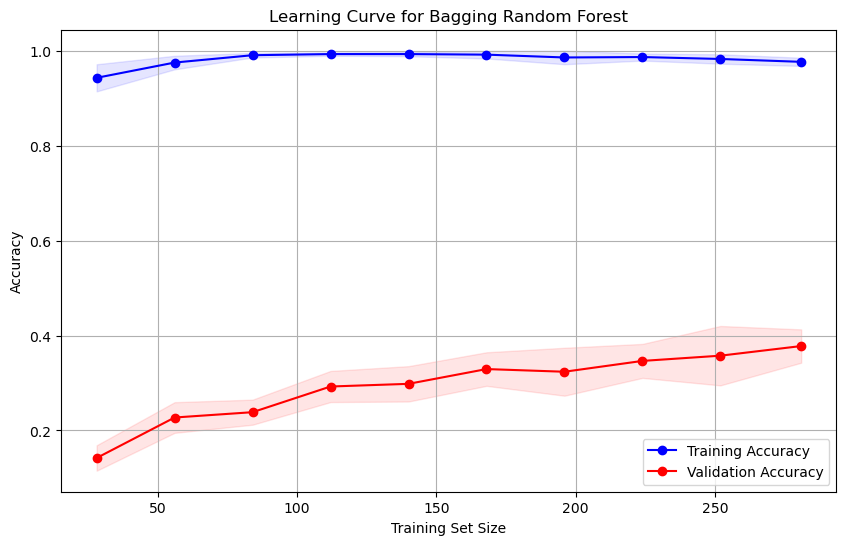

In [57]:
from sklearn.model_selection import learning_curve

# Set up the BaggingClassifier with RandomForest as the base estimator
model = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42),
    n_estimators=10,  # Number of bagged estimators (i.e., the number of Random Forest models in the ensemble)
    bootstrap=True,   # Enable bootstrapping for each base estimator
    random_state=42
)

# Fit the BaggingClassifier on the training data
model.fit(X_train, y_train_encoded)

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train_encoded, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker='o')
plt.plot(train_sizes, val_mean, label="Validation Accuracy", color="red", marker='o')

# Fill between with standard deviations
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.1)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Bagging Random Forest")
plt.legend(loc="best")
plt.grid()
plt.show()

Interpreting the Learning Curve

* Training Accuracy: Shows how well the model performs on the training data.
* Validation Accuracy: Shows how well the model generalizes to unseen data.
* Gap Between Curves: A large gap with high training accuracy and low validation accuracy indicates overfitting. A small gap with both high training and validation accuracy suggests good generalization.

This graph shows concerning results, as it indicates that the model is quite effective at learning patterns in the training data and quickly improves its accuracy dramatically, almost reaching 100%. Despite this, it does extremely poorly in the validation set. While showing steady improvements as the training set size increases, its best performance cannot even reach 40% accuracy, as the model excessively overfit the data.

##### Plotting Accuracy Across Training Rounds
This plot gives a visual understanding of how the model’s performance evolves as more rounds are added to the ensemble, helping identify the optimal ensemble size. 

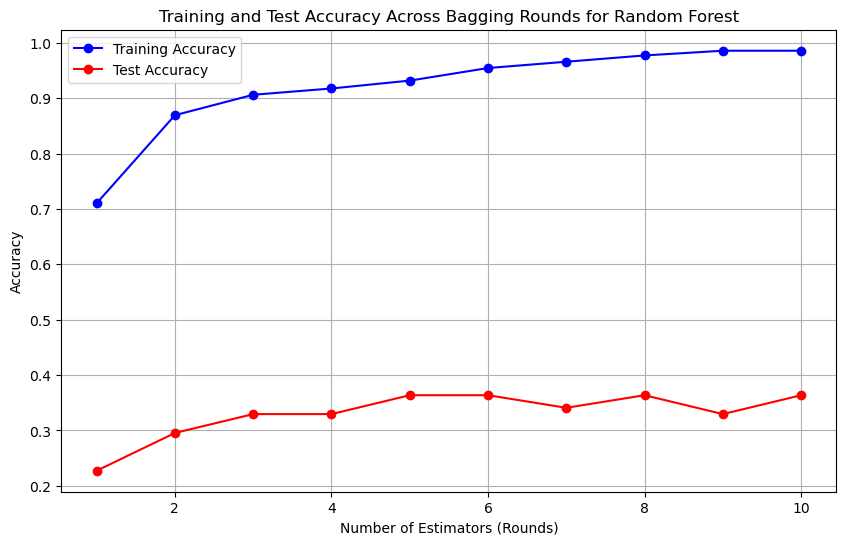

In [59]:
# Initialize lists to store accuracies for each round
train_accuracies = []
test_accuracies = []
n_estimators = 10  # Number of bagging rounds to evaluate

# Loop over each round of bagging, increasing the number of estimators each time
for i in range(1, n_estimators + 1):
    # Define the Bagging Random Forest model with increasing number of estimators
    model = BaggingClassifier(
        estimator=RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42),
        n_estimators=i,  # Number of bagged estimators
        bootstrap=True,
        random_state=42
    )
    
    # Fit the model on the training data
    model.fit(X_train, y_train_encoded)
    
    # Calculate accuracy for training and test sets
    train_accuracy = accuracy_score(y_train_encoded, model.predict(X_train))
    test_accuracy = accuracy_score(y_test_encoded, model.predict(X_test))
    
    # Store the accuracies
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot Training and Test Accuracy Across Training Rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators + 1), train_accuracies, label="Training Accuracy", marker='o', color="blue")
plt.plot(range(1, n_estimators + 1), test_accuracies, label="Test Accuracy", marker='o', color="red")
plt.xlabel("Number of Estimators (Rounds)")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy Across Bagging Rounds for Random Forest")
plt.legend(loc="best")
plt.grid()
plt.show()

Interpreting the Plot
* Increasing Accuracy with More Estimators: If both lines increase as the number of estimators grows, the model benefits from the additional bagging rounds.
* Plateauing or Dipping Test Accuracy: Indicates the point where adding more estimators does not improve generalization or might start leading to overfitting.

Once again, the model performs quite well in the training set as the increased bagging rounds consistently increase the accuracy of classification. However, unlike the previous graphs in which performance continued to increase in the validation set despite being poor overall, such improvement is not seen in this case. While the general trend is upward, the results are much more irregular, constantly experiencing plateaus or outright losses in accuracy, also being clear signs of overfitting.

##### Visualizing Training and Validation Loss for Logistic Regression
To visualize training and validation loss for the Random Forest model, log-loss (or negative log-likelihood loss) will be used, which provides a measure of how well the predicted probabilities align with the true labels. Although Random Forest is not typically optimized with log-loss, we can still calculate and plot it to understand model calibration over training and validation data.

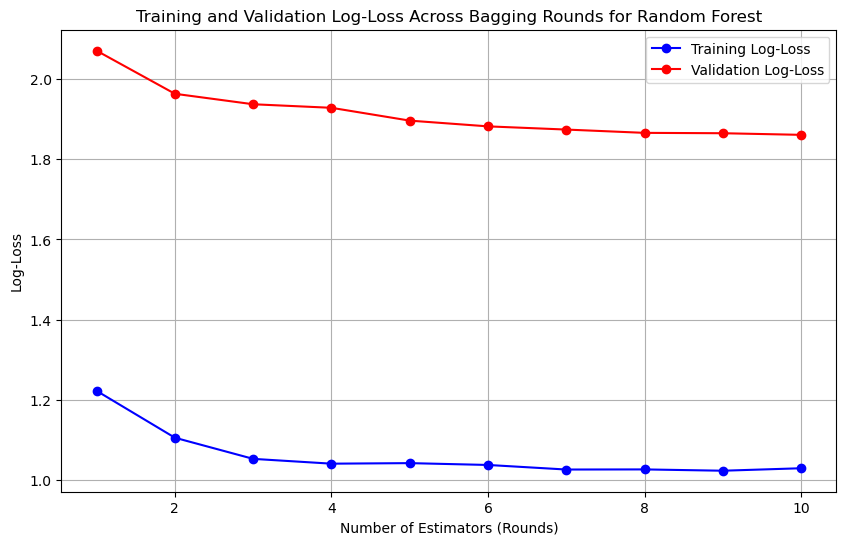

In [60]:
from sklearn.metrics import log_loss

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []
n_rounds = 10  # Number of bagging rounds to evaluate

# Loop over each round of bagging, increasing the number of estimators each time
for i in range(1, n_rounds + 1):
    # Define the Bagging Random Forest model with increasing number of estimators
    model = BaggingClassifier(
        estimator=RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42),
        n_estimators=i,
        bootstrap=True,
        random_state=42
    )
    
    # Fit the model on the training data
    model.fit(X_train, y_train_encoded)
    
    # Predict probabilities on training and validation sets
    y_train_pred_proba = model.predict_proba(X_train)
    y_val_pred_proba = model.predict_proba(X_test)
    
    # Calculate log-loss for training and validation data
    train_loss = log_loss(y_train_encoded, y_train_pred_proba)
    val_loss = log_loss(y_test_encoded, y_val_pred_proba)
    
    # Store the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot Training and Validation Loss Across Bagging Rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_rounds + 1), train_losses, label="Training Log-Loss", marker='o', color="blue")
plt.plot(range(1, n_rounds + 1), val_losses, label="Validation Log-Loss", marker='o', color="red")
plt.xlabel("Number of Estimators (Rounds)")
plt.ylabel("Log-Loss")
plt.title("Training and Validation Log-Loss Across Bagging Rounds for Random Forest")
plt.legend(loc="best")
plt.grid()
plt.show()

Interpreting the Plot
* Decreasing Log-Loss: Indicates that the model is learning better class probabilities, improving its confidence in predictions.
* Plateauing Log-Loss: Shows that adding more rounds doesn’t improve model calibration and performance further.
* Diverging Curves: If training log-loss keeps decreasing while validation log-loss increases, this suggests overfitting.

This plot is the least concerning, as it is expected that loss curves in training sets should be lower than those of the validation set (though not in such magnitude, as clear overfitting is shown here). Despite the mentioned flaw, losses in both training and validation sets continue to decrease as the number of rounds increases until leveling off at some point, which is proper of well-behaved loss curves.

## Summary

Despite seeing undesirable performance from various machine learning algorithms, evaluating the models with cross-validation helped recognize that the results obtained, though not optimal, were consistent and generalizable. After this, ensemble learning methods were attempted, and the results, while mostly similar, were somewhat promising. Because of this, bagged Random Forest, the best-performing model was assessed more thoroughly. The results were however disappointing, as the comparison of the accuracy and loss curves showed clear signs of overfitting despite good training results. Having observed that both clustering and classic machine learning methods (despite the added sophistication of ensemble learning) were not effective in correctly classifying the images in the dataset, deep learning methods seem like the most logical models to explore next, as they tend to be the better-performing options for the specific task of image classification. However, it might be worth exploring the efficiency of training in terms of runtime beforehand.